virtual env: myenv

# Requirements:
- keras==2.2.4
- tensorflow==1.13.1
- protobuf==3.20.*

# Importings

In [ ]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
from seqeval.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#import tensorflow_addons as tfa
from keras.layers import Input
from keras.models import Model
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
#from tensorflow_addons.layers import CRF
from keras_contrib import losses
from keras_contrib import metrics

In [ ]:
# check for physical devices
from tensorflow.python.client import device_lib
import tensorflow as tf
print("Num of GPUs available: ", len(tf.test.gpu_device_name()))

# Description of the model:
* Our model is a combinaition of Bi-LSTM and CRF models
## - Input: 
X = an array of sentences where a sentence is a list of claim segments. To prepare data for the model we add "PAD" values to make all of them the same length then we convert sentences to numerical values using  word2idx, then we use pad_sequence method to get a 2D array shape
## - Output:
y = an array of tags where a tag is a list containing binary values for each element in the sequence

In [2]:
def get_words(df):
    words = []
    for i in range(len(df)):
        words.append(ast.literal_eval(df['claim_segments'][i]))
    words = [item for sublist in words for item in sublist]
    words = [*set(words)]
    words.append("ENDPAD")
    return words

def FindMaxLength(lst):
    maxList = max(lst, key = lambda i: len(i))
    maxLength = len(maxList)
     
    return maxLength

In [3]:
df = pd.read_csv('./uspto_df_final.csv')
words = get_words(df)
sentences = df['claim_segments'].to_list()
sentences = [ast.literal_eval(x) for x in sentences]
tags = df['claim_segments_binary'].to_list()
tags = [ast.literal_eval(x) for x in tags]
for i in range(len(sentences)):
    sentences[i] = list(zip(sentences[i], tags[i]))
tags = [0,1]

In [4]:
sentences[0]

[('ornamental', 0),
 ('design', 1),
 ('for', 0),
 ('candy,', 0),
 ('as', 0),
 ('shown', 0),
 ('and', 0),
 ('described.', 1)]

Convert the input and output to numerical data and pad the sequence to be the same length because the model accept only sentences with the same length.

In [5]:
max_len = FindMaxLength(sentences)
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
n_words = len(words)
n_tags = len(tags)
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx[0])
y = [to_categorical(i, num_classes=n_tags) for i in y]

Split data into 80% train set and 20% for the test set 

In [6]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

# Preparing the model Architecture
* First layer: takes an input of size max len where max len is the mean length of sentences.
* Second layers:  We fit the LSTM-CRF model with a 20-dimension embedding layer.
* Third layer:  Our BiLSTM model
* Fouth layer:  We add a dense layer for regularization to preventing the co-adaptation of neurons
* Fifth layer: Our CRF model
* Sixth layer: the output layer of the model

In [ ]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len)(input) 
model = Bidirectional(LSTM(units=20, return_sequences=True,
                           recurrent_dropout=0))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags) 
out = crf(model)


## Specifications:
- Optimizer: Adam
- Loss: categorical cross entropy
- Metrics : accuracy



In [9]:
model = Model(input, out)
model.compile(optimizer="Adam", loss=crf.loss_function, metrics=[metrics.crf_accuracy])
model.summary()
y_tr = np.array(y_tr)
X_tr = X_tr.astype(np.int32)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33595)]           0         
                                                                 
 embedding (Embedding)       (None, 33595, 20)         9128120   
                                                                 
 bidirectional (Bidirectiona  (None, 33595, 40)        6560      
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 33595, 50)        2050      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 33595, 2)          110       
                                                                 
Total params: 9,136,840
Trainable params: 9,136,840
Non-train

/home/smidab/anaconda3/lib/python3.9/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '


After preparing the architecture, we fit the model to our data with these preliminary values:
- Validation split : 0.1
- Batch size : 32
- Number of epochs :1

In [ ]:
history = model.fit(X_tr, y_tr, batch_size = 32, epochs = 1, validation_split = 0.1, verbose = 1)

In [ ]:
hist = pd.DataFrame(history.history)


In [27]:
hist

,val_loss,val_crf_accuracy,loss,crf_accuracy
0,44.031399,0.938923,43.289721,0.893687
1,43.953662,0.967843,43.077074,0.959064
2,43.941977,0.970591,43.044106,0.969307
3,43.940503,0.971544,43.033995,0.972355
4,43.934126,0.972930,43.027902,0.974496


# Plot the learning curve

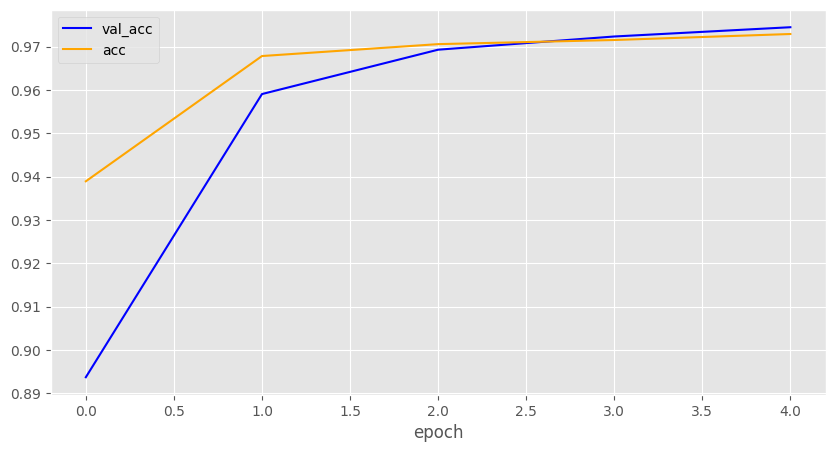

In [28]:
plt.style.use("ggplot")
plt.figure(figsize=(10,5))
plt.plot(hist["crf_accuracy"],label = 'val_acc',color='blue')
plt.plot(hist["val_crf_accuracy"],label = 'acc',color='orange')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Evaluate the model

In [29]:
test_pred = model.predict(X_te, verbose=1)

730/730 [==============================] - 42s 58ms/step


In [62]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(p_i)
        out.append(out_i)
    return out

In [73]:
pred_labels = np.array(pred2label(test_pred))
test_labels = np.array(pred2label(y_te))

# Print the classification report

In [ ]:
report = classification_report(test_labels, pred_labels)

In [79]:
print(report)

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.89      0.93      0.91       179
           2       0.93      0.84      0.88       138
           3       0.77      0.92      0.84       137
           4       0.77      0.86      0.81       101
           5       0.62      0.79      0.69        52
           6       0.64      0.84      0.72        75
           7       0.69      0.84      0.76        97
           8       0.74      0.94      0.83        99
           9       0.79      0.88      0.83       132
          10       0.74      0.89      0.81       101
          11       0.79      0.93      0.85        96
          12       0.84      0.90      0.87        93
          13       0.83      0.93      0.88       102
          14       0.78      0.89      0.83        85
          15       0.85      0.94      0.89        97
          16       0.88      0.90      0.89        84
          17       0.91    

In [81]:
i = 300
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

Word           ||True ||Pred
refusing       :     0 0
attention      :     0 0
alkaline       :     0 0
interplay      :     0 1
bendable;      :     0 0
dequantizing   :     0 0
MCHC           :     0 0
and,slits      :     0 0
axiswherein    :     0 0
detected,in    :     0 0
sealingly      :     0 0
salt;          :     0 0
delay          :     0 0
snapably       :     0 1
bendable;      :     0 0
earns          :     0 0
spaces         :     1 1
flags,         :     0 0
bendable;      :     0 0
A24            :     0 0
Va;            :     0 0
salt;          :     0 0
RH             :     0 0
tr[sub]        :     0 0
A24            :     0 0
Va;            :     0 0
(OOV)          :     0 0
magnetic-field :     0 0
folded.,;      :     0 0
trenches       :     0 0
Va;            :     0 0
RSSIs          :     0 0
film           :     0 0
harvesting,    :     0 0
snapably       :     1 1
bendable;      :     0 0
terminalwherein:     0 0
light-converting:     0 0
camshift       :    

### Try on an example

In [ ]:
test_sentence = ["Hawking", "was", "a", "Fellow", "of", "the", "Royal", "Society", ",", "a", "lifetime", "member",
                 "of", "the", "Pontifical", "Academy", "of", "Sciences", ",", "and", "a", "recipient", "of",
                 "the", "Presidential", "Medal", "of", "Freedom", ",", "the", "highest", "civilian", "award",
                 "in", "the", "United", "States", "."]

In [ ]:
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=0, maxlen=max_len)

In [ ]:
tags

In [ ]:
p = model.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(test_sentence, p[0]):
    print("{:15}: {:5}".format(w, tags[pred]))
